# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_8', 'ORACLE.run1_14', 'ORACLE.run1_38', 'ORACLE.run1_26', 'ORACLE.run1_44', 'ORACLE.run1_50'}


{'ORACLE.run2_32', 'ORACLE.run2_38', 'ORACLE.run2_20', 'ORACLE.run2_26', 'ORACLE.run2_44', 'ORACLE.run2_14', 'ORACLE.run2_8', 'ORACLE.run2_50'}


tensor([[[ 0.5430,  0.9459, -0.9634,  ..., -0.7357,  0.5080, -0.8058],
         [-0.4204,  0.3854,  0.1226,  ..., -0.4204, -1.1386, -0.9284]],

        [[ 0.1073,  1.2338, -0.4828,  ..., -0.9477,  0.3576, -0.9835],
         [-0.6795,  0.0894,  0.5901,  ..., -0.1073, -1.0729, -0.6080]],

        [[-1.0279,  0.4508,  1.4246,  ..., -0.5049,  0.1984,  1.2623],
         [-0.3066, -0.2525,  0.0361,  ...,  1.1722,  1.0459,  0.1803]],

        ...,

        [[-0.3467,  0.2836,  0.3782,  ..., -0.4412, -1.4339, -1.0242],
         [-0.2836, -1.1345,  0.5988,  ...,  0.9770, -0.5673,  0.3624]],

        [[ 0.5706, -0.4935, -0.6014,  ...,  0.2776,  1.3416,  0.6477],
         [ 0.9098,  0.9252, -1.0486,  ..., -0.7710,  0.4163, -0.9561]],

        [[ 0.4556, -0.7542, -0.5656,  ...,  0.8956,  1.0841,  0.3928],
         [ 1.0684,  0.8013, -1.1627,  ..., -0.4871,  0.4714, -1.2098]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.5605, train_label_loss: 2.9187, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2303.8429, train_label_loss: 1.6592, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2302.3410, train_label_loss: 0.7357, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2302.9664, train_label_loss: 0.7290, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2299.7224, train_label_loss: 0.5670, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2304.2478, train_label_loss: 0.5410, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2295.2119, train_label_loss: 0.6328, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2292.7273, train_label_loss: 0.4294, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2295.6622, train_label_loss: 0.5701, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2420.0334, train_label_loss: 0.6145, 


epoch: 1, source_val_acc_label: 0.7296, target_val_acc_label: 0.7140, source_val_label_loss: 0.9710, target_val_label_loss: 0.9883, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.2018, train_label_loss: 0.8352, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2313.8409, train_label_loss: 0.8532, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2303.4614, train_label_loss: 0.3959, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2474.2823, train_label_loss: 0.7818, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2599.7399, train_label_loss: 0.4742, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2625.1443, train_label_loss: 0.3738, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2621.9544, train_label_loss: 0.5970, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2572.8218, train_label_loss: 0.4815, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2630.5708, train_label_loss: 0.8795, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2862.9477, train_label_loss: 0.2338, 


epoch: 2, source_val_acc_label: 0.8402, target_val_acc_label: 0.8206, source_val_label_loss: 0.4440, target_val_label_loss: 0.5137, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.7863, train_label_loss: 0.7545, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2325.9333, train_label_loss: 0.4987, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2319.1965, train_label_loss: 0.2043, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2334.3347, train_label_loss: 0.1544, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2308.0681, train_label_loss: 0.4949, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2320.8993, train_label_loss: 0.3224, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2326.3158, train_label_loss: 0.4204, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2296.6997, train_label_loss: 0.5051, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2312.3508, train_label_loss: 0.4802, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2402.9341, train_label_loss: 0.5212, 


epoch: 3, source_val_acc_label: 0.8712, target_val_acc_label: 0.8539, source_val_label_loss: 0.3616, target_val_label_loss: 0.4345, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.2909, train_label_loss: 0.2961, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2585.1205, train_label_loss: 0.2564, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2587.8413, train_label_loss: 0.3279, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2591.8648, train_label_loss: 0.1659, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2622.7307, train_label_loss: 0.3081, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2586.7059, train_label_loss: 0.5380, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2614.8506, train_label_loss: 0.2818, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2596.9710, train_label_loss: 0.8330, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3138.1737, train_label_loss: 0.4068, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3433.8320, train_label_loss: 0.2773, 


epoch: 4, source_val_acc_label: 0.8857, target_val_acc_label: 0.8634, source_val_label_loss: 0.3130, target_val_label_loss: 0.4011, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.1600, train_label_loss: 0.2810, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3512.2302, train_label_loss: 0.3614, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3942.9255, train_label_loss: 0.2825, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3530.7111, train_label_loss: 0.0800, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2963.9906, train_label_loss: 0.3461, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2945.6141, train_label_loss: 0.1377, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2725.5016, train_label_loss: 0.1241, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2303.1573, train_label_loss: 0.1714, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2325.4350, train_label_loss: 0.1025, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2306.7530, train_label_loss: 0.3062, 


epoch: 5, source_val_acc_label: 0.8926, target_val_acc_label: 0.8682, source_val_label_loss: 0.2995, target_val_label_loss: 0.3894, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 1.9954, train_label_loss: 0.4842, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2310.3606, train_label_loss: 0.3366, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2318.3870, train_label_loss: 0.1961, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2467.1124, train_label_loss: 0.1616, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2617.8973, train_label_loss: 0.2420, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2714.8651, train_label_loss: 0.1401, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2373.2739, train_label_loss: 0.2901, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2355.5532, train_label_loss: 0.3309, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2318.1422, train_label_loss: 0.0286, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2325.6694, train_label_loss: 0.6663, 


epoch: 6, source_val_acc_label: 0.8931, target_val_acc_label: 0.8653, source_val_label_loss: 0.2995, target_val_label_loss: 0.4035, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 0.5576, train_label_loss: 0.2677, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3489.1586, train_label_loss: 0.2097, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3389.0403, train_label_loss: 0.5243, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3798.5199, train_label_loss: 0.2547, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3950.2389, train_label_loss: 0.1610, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 4083.8759, train_label_loss: 0.2249, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3999.5370, train_label_loss: 0.1825, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3340.4159, train_label_loss: 0.2193, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3005.9646, train_label_loss: 0.1758, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3026.7691, train_label_loss: 0.1486, 


epoch: 7, source_val_acc_label: 0.8944, target_val_acc_label: 0.8646, source_val_label_loss: 0.2975, target_val_label_loss: 0.4348, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.7833, train_label_loss: 0.2653, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3000.2379, train_label_loss: 0.2710, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3258.7910, train_label_loss: 0.0797, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3437.1719, train_label_loss: 0.3282, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3488.9146, train_label_loss: 0.1241, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3024.7555, train_label_loss: 0.1441, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2993.5545, train_label_loss: 0.4717, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2948.0155, train_label_loss: 0.1092, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3004.4154, train_label_loss: 0.2250, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3013.3500, train_label_loss: 0.2639, 


epoch: 8, source_val_acc_label: 0.9106, target_val_acc_label: 0.8778, source_val_label_loss: 0.2523, target_val_label_loss: 0.4202, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.7959, train_label_loss: 0.0663, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3051.4664, train_label_loss: 0.1620, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3507.1918, train_label_loss: 0.1600, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3459.8430, train_label_loss: 0.4715, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3227.7836, train_label_loss: 0.1265, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3017.9413, train_label_loss: 0.3901, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2974.5417, train_label_loss: 0.0840, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2957.5001, train_label_loss: 0.1849, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3084.5765, train_label_loss: 0.0375, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3003.9245, train_label_loss: 0.2020, 


epoch: 9, source_val_acc_label: 0.9049, target_val_acc_label: 0.8724, source_val_label_loss: 0.2670, target_val_label_loss: 0.4528, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.7821, train_label_loss: 0.0673, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3316.9660, train_label_loss: 0.0293, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3427.9217, train_label_loss: 0.1034, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3492.9448, train_label_loss: 0.0969, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2965.5248, train_label_loss: 0.2377, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3004.6138, train_label_loss: 0.0790, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2976.3987, train_label_loss: 0.3219, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2992.0628, train_label_loss: 0.0932, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2981.6044, train_label_loss: 0.0120, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2961.4626, train_label_loss: 0.5243, 


epoch: 10, source_val_acc_label: 0.8872, target_val_acc_label: 0.8561, source_val_label_loss: 0.3291, target_val_label_loss: 0.4717, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.8090, train_label_loss: 0.0822, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3418.3013, train_label_loss: 0.1222, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3641.8909, train_label_loss: 0.4485, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2975.5715, train_label_loss: 0.0745, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2950.0287, train_label_loss: 0.3635, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2968.3287, train_label_loss: 0.1169, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2962.0480, train_label_loss: 0.2830, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3301.4096, train_label_loss: 0.0350, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3386.4492, train_label_loss: 0.1133, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3353.4150, train_label_loss: 0.0810, 


epoch: 11, source_val_acc_label: 0.9077, target_val_acc_label: 0.8746, source_val_label_loss: 0.2704, target_val_label_loss: 0.4206, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.3450, train_label_loss: 0.2367, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 4556.2137, train_label_loss: 0.2796, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3960.6725, train_label_loss: 0.0622, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2984.9885, train_label_loss: 0.2845, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3013.6237, train_label_loss: 0.2637, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3027.7713, train_label_loss: 0.1215, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3023.9778, train_label_loss: 0.5887, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3016.5976, train_label_loss: 0.2725, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3031.1996, train_label_loss: 0.2016, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2982.0891, train_label_loss: 0.2613, 


epoch: 12, source_val_acc_label: 0.9104, target_val_acc_label: 0.8780, source_val_label_loss: 0.2552, target_val_label_loss: 0.4188, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.9709, train_label_loss: 0.4883, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3062.6197, train_label_loss: 0.0477, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3030.6668, train_label_loss: 0.2396, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3009.7508, train_label_loss: 0.1343, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3018.1501, train_label_loss: 0.1056, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3036.0526, train_label_loss: 0.0535, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2971.5525, train_label_loss: 0.0394, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2997.0138, train_label_loss: 0.2980, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3023.5845, train_label_loss: 0.0946, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2999.1491, train_label_loss: 0.2024, 


epoch: 13, source_val_acc_label: 0.9086, target_val_acc_label: 0.8731, source_val_label_loss: 0.2658, target_val_label_loss: 0.4450, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.1483, train_label_loss: 0.2541, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3426.6459, train_label_loss: 0.0675, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3431.5537, train_label_loss: 0.1160, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3484.3929, train_label_loss: 0.1056, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3498.7693, train_label_loss: 0.0339, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3456.7937, train_label_loss: 0.1747, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3421.3766, train_label_loss: 0.1617, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3437.7109, train_label_loss: 0.0054, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3785.1896, train_label_loss: 0.0330, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3877.8863, train_label_loss: 0.0127, 


epoch: 14, source_val_acc_label: 0.9046, target_val_acc_label: 0.8739, source_val_label_loss: 0.2800, target_val_label_loss: 0.4719, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 3.9540, train_label_loss: 0.1207, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3881.3520, train_label_loss: 0.1234, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3908.0391, train_label_loss: 0.3047, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3825.0686, train_label_loss: 0.0144, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3807.6947, train_label_loss: 0.1576, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 4096.3407, train_label_loss: 0.1251, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3942.9180, train_label_loss: 0.1299, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3856.4494, train_label_loss: 0.2512, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3256.1053, train_label_loss: 0.0277, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2970.4018, train_label_loss: 0.0620, 


epoch: 15, source_val_acc_label: 0.9092, target_val_acc_label: 0.8728, source_val_label_loss: 0.2675, target_val_label_loss: 0.4877, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.7535, train_label_loss: 0.0783, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2958.1588, train_label_loss: 0.3918, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2980.7408, train_label_loss: 0.1300, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3244.3410, train_label_loss: 0.0796, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3333.6875, train_label_loss: 0.2639, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3652.6863, train_label_loss: 0.0087, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3859.1498, train_label_loss: 0.2982, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3677.1447, train_label_loss: 0.0112, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3493.6276, train_label_loss: 0.1174, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3414.7195, train_label_loss: 0.1550, 


epoch: 16, source_val_acc_label: 0.9137, target_val_acc_label: 0.8765, source_val_label_loss: 0.2636, target_val_label_loss: 0.4877, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

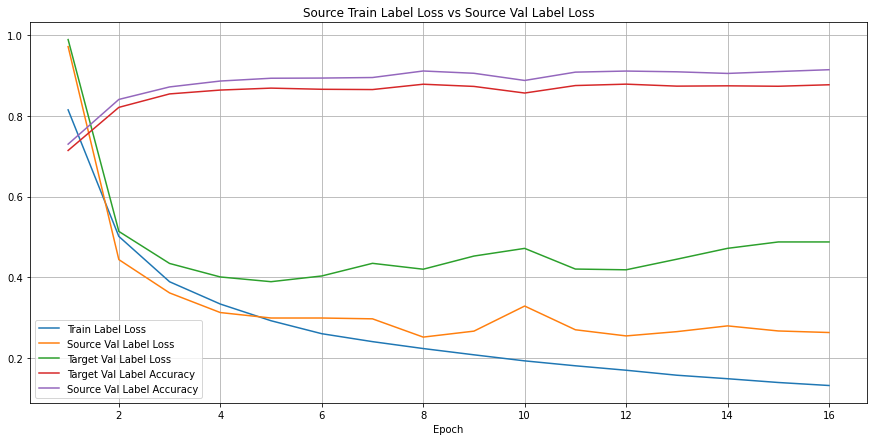

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

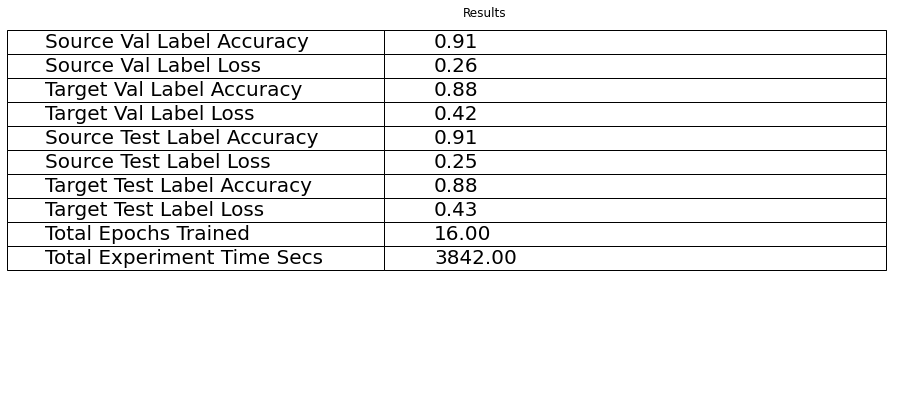

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

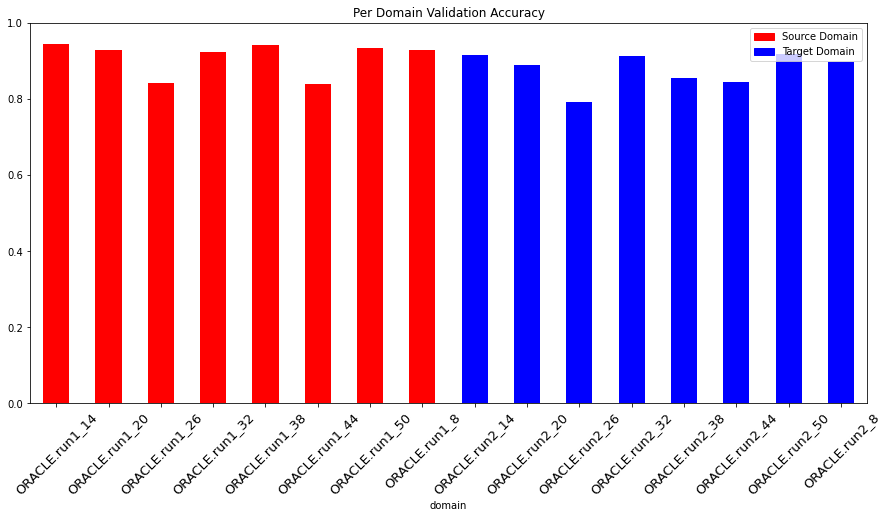

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9133463541666667 Target Test Label Accuracy: 0.8783854166666667
Source Val Label Accuracy: 0.9104166666666667 Target Val Label Accuracy: 0.87802734375


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048